### Necessary Packages

In [1]:
import os
import sys
sys.path.append("../..")
import torch
import pandas as pd
import numpy as np
import imagesize
import seaborn as sns
import matplotlib.pyplot as plt
import dotenv
from PIL import Image
from tqdm.notebook import tqdm
from src.transforms import make_patches,ImageResizer
from torchvision.transforms import functional as F

In [2]:
sns.set_theme(style="whitegrid",palette="Set2")

In [3]:
tqdm.pandas()

### Loading envirement variables

In [4]:
ROI_FOLDER = dotenv.get_key(dotenv.find_dotenv(), "ROI_FOLDER")
PARENT_DIR = os.path.dirname(ROI_FOLDER)

In [5]:
DESCRIPTION_DF_PATH = os.path.join(PARENT_DIR, "description_df.csv")

### Loading the description dataframe

In [6]:
def build_df(data_dir):

    splits = os.listdir(data_dir)
    
    df = {
        "path": [],
        "split": [],
        "category": [],
    }
    
    for split in splits:

        split_dir = os.path.join(data_dir, split)
        categories = os.listdir(split_dir)

        for category in categories:

            category_dir = os.path.join(split_dir,category)

            for roi in os.listdir(category_dir):
                roi_path = os.path.join(category_dir, roi)
                df["path"].append(roi_path)
                df["split"].append(split)
                df["category"].append(category)

    df = pd.DataFrame(df)
    df["size"] = df.path.apply(os.path.getsize)
    df["resolution"] = df.path.progress_apply(imagesize.get)
    df["width"] = df["resolution"].apply(lambda x : x[0])
    df["height"] = df["resolution"].apply(lambda x : x[1])

    mapper = {
        "0_N":"benign",
        "1_PB":"benign",
        "2_UDH":"benign",
        "3_FEA":"atypical",
        "4_ADH":"atypical",
        "5_DCIS":"malignant",
        "6_IC":"malignant"
    }

    df["path"] = df["path"] \
        .apply(lambda x : x.replace(data_dir,'')) \
        .apply(lambda x : x[len(os.path.sep):])

    df["label"] = df["category"].map(mapper)

    df["patches_count"] = df["resolution"] \
        .apply(lambda r : ImageResizer.get_new_dimensions(r[0], r[1])) \
        .apply(lambda r : int((r[0] / 224) * (r[1] / 224)))

    return df

In [7]:
df = None

if not os.path.exists(DESCRIPTION_DF_PATH):
    df = build_df(ROI_FOLDER)
    df.to_csv(DESCRIPTION_DF_PATH,index=False)
else:
    df = pd.read_csv(DESCRIPTION_DF_PATH)
    df["resolution"] = df["resolution"].apply(
        lambda x : (int(x[1:-1].split(',')[0]),int(x[1:-1].split(',')[1]))
    )

In [8]:
df.head()

,path,split,category,size,resolution,width,height,label,patches_count
0,train/3_FEA/BRACS_1811_FEA_35.png,train,3_FEA,1747625,"(806, 795)",806,795,atypical,16
1,train/3_FEA/BRACS_747_FEA_4.png,train,3_FEA,8365724,"(1441, 2355)",1441,2355,atypical,66
2,train/3_FEA/BRACS_1771_FEA_63.png,train,3_FEA,3321943,"(959, 1246)",959,1246,atypical,24
3,train/3_FEA/BRACS_754_FEA_24.png,train,3_FEA,1370381,"(581, 867)",581,867,atypical,12
4,train/3_FEA/BRACS_1877_FEA_12.png,train,3_FEA,1176420,"(669, 617)",669,617,atypical,9


### Plots

<Axes: xlabel='split', ylabel='count'>

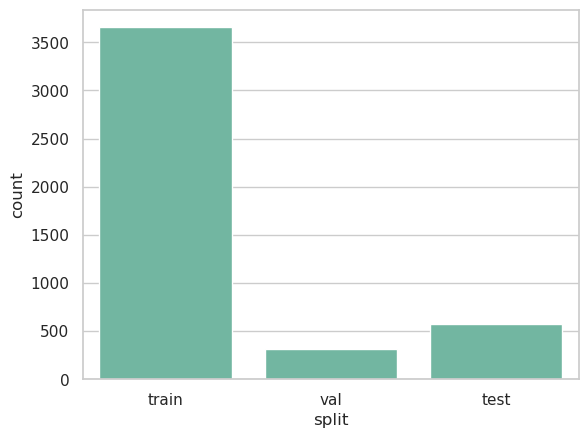

In [9]:
sns.countplot(data=df, x='split')

<Axes: xlabel='category', ylabel='count'>

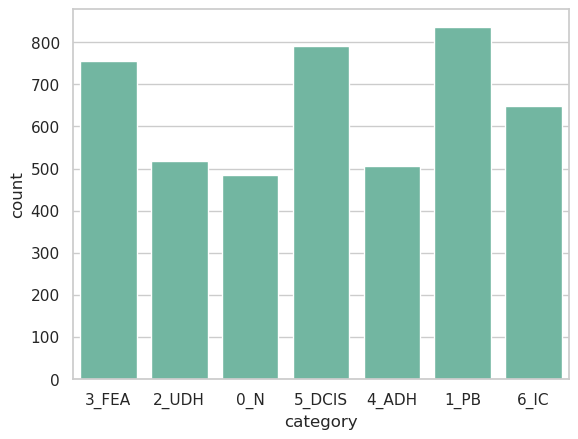

In [10]:
sns.countplot(data=df, x='category')

<Axes: xlabel='label', ylabel='count'>

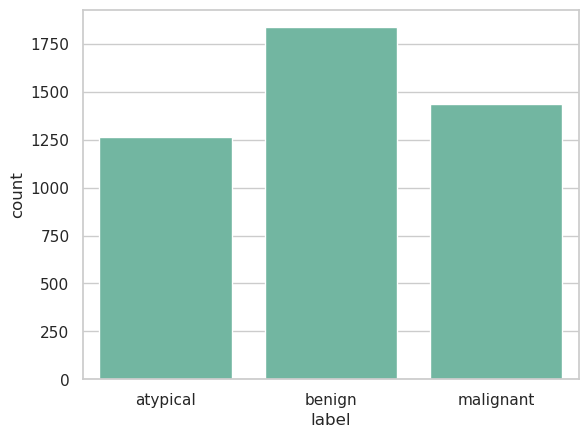

In [11]:
sns.countplot(data=df, x='label')

<Axes: xlabel='split', ylabel='count'>

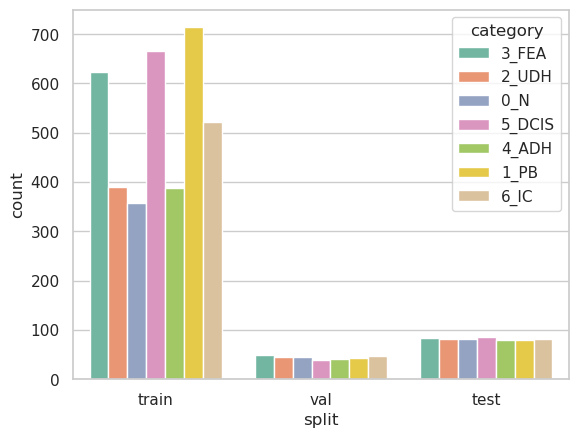

In [12]:
sns.countplot(data=df, x='split', hue='category')

<Axes: xlabel='split', ylabel='count'>

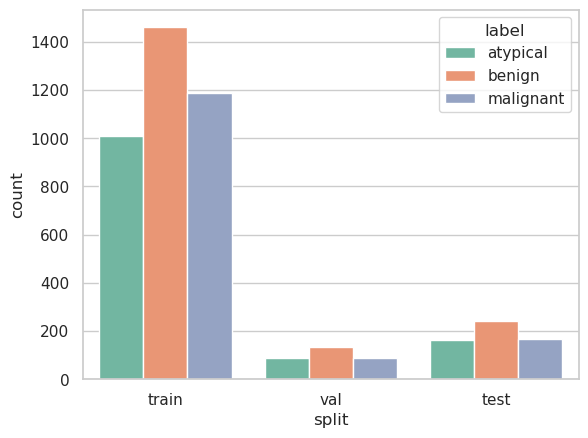

In [13]:
sns.countplot(data=df, x='split', hue='label')

### Frequency Plots after patching

In [14]:
df["patches_count"].sum()

404424

<Axes: xlabel='split', ylabel='patches_count'>

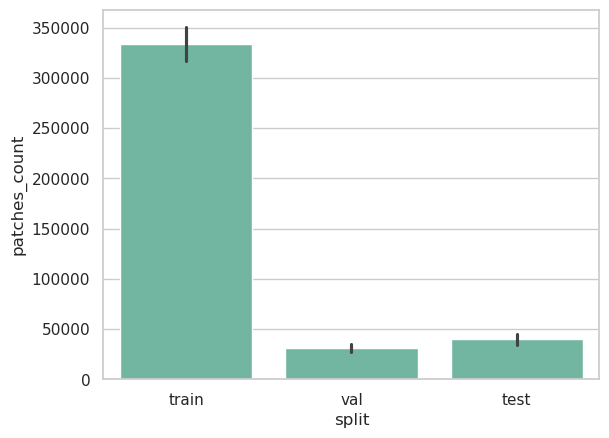

In [15]:
sns.barplot(data=df, x="split", y="patches_count", estimator=np.sum)

<Axes: xlabel='category', ylabel='patches_count'>

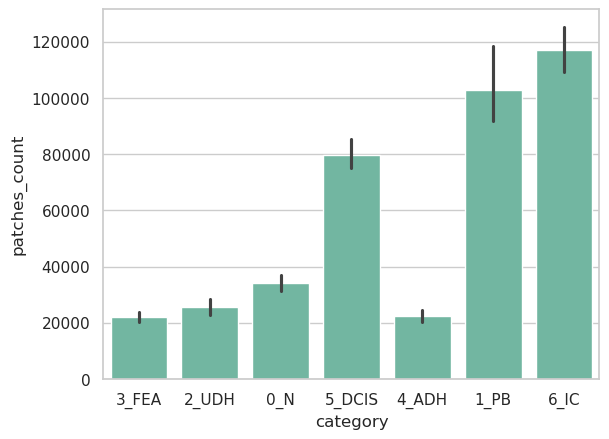

In [16]:
sns.barplot(data=df, x="category", y="patches_count", estimator=np.sum)

<Axes: xlabel='label', ylabel='patches_count'>

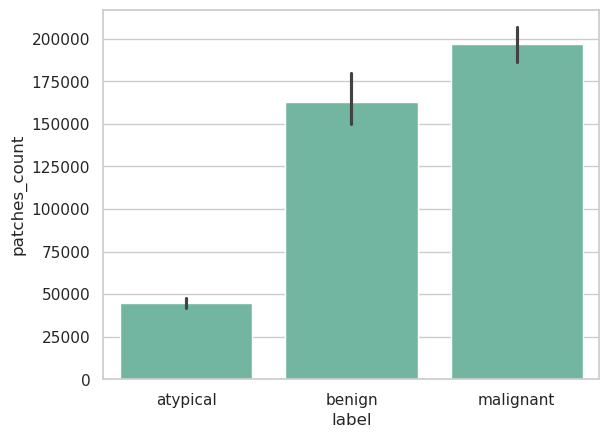

In [17]:
sns.barplot(data=df, x="label", y="patches_count", estimator=np.sum)

<Axes: xlabel='split', ylabel='patches_count'>

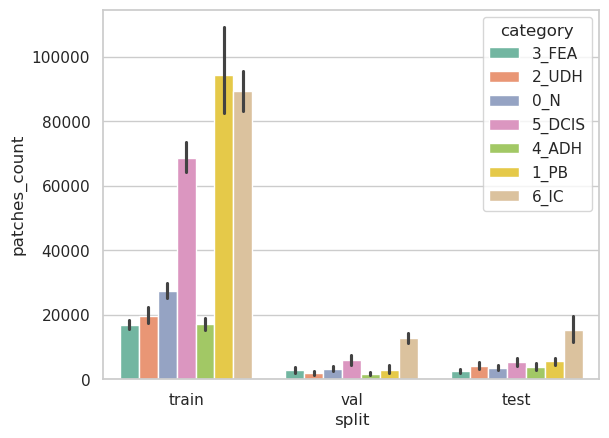

In [18]:
sns.barplot(data=df, x="split", y="patches_count", hue="category", estimator=np.sum)

<Axes: xlabel='split', ylabel='patches_count'>

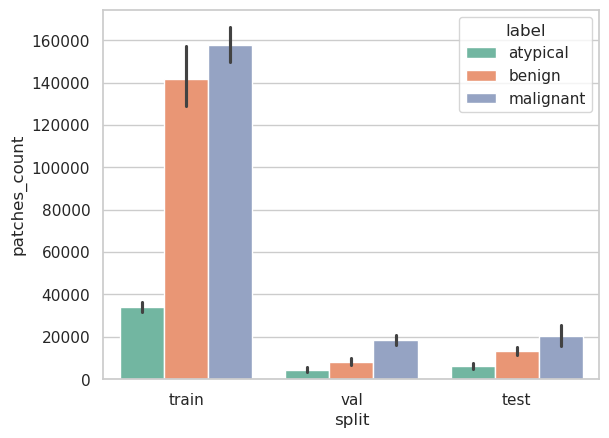

In [19]:
sns.barplot(data=df, x="split", y="patches_count", hue="label", estimator=np.sum)

### Visualizing the images

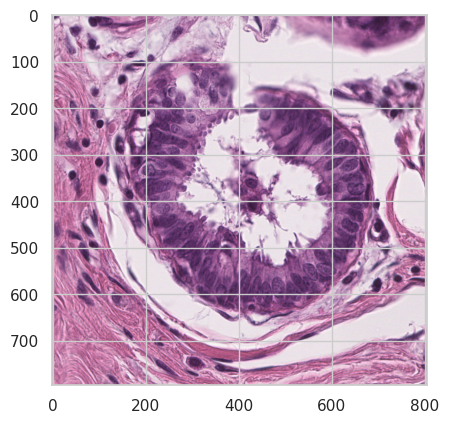

In [20]:
path = os.path.join(ROI_FOLDER, df.path.iloc[0])
test_img = Image.open(path)
plt.imshow(test_img)

### Image Patching

In [21]:
resizer = ImageResizer()
resized_img = resizer(test_img)
tensor_img = F.to_tensor(resized_img)
patches = make_patches(tensor_img, patch_height=224,patch_width=224,return_tensor=True)
print(f"langth = {patches.shape}, type = {type(patches)}")

langth = torch.Size([4, 4, 3, 224, 224]), type = <class 'torch.Tensor'>


In [22]:
def plot_paches(patches : torch.Tensor) -> None:

    H,W,_,_,_ = patches.shape

    fig, axes = plt.subplots(H,W,figsize=(10,10))

    for i,row in enumerate(axes):
        for j,ax in enumerate(row):
            ax.imshow(patches[i,j].permute(1,2,0))
            ax.axis('off')

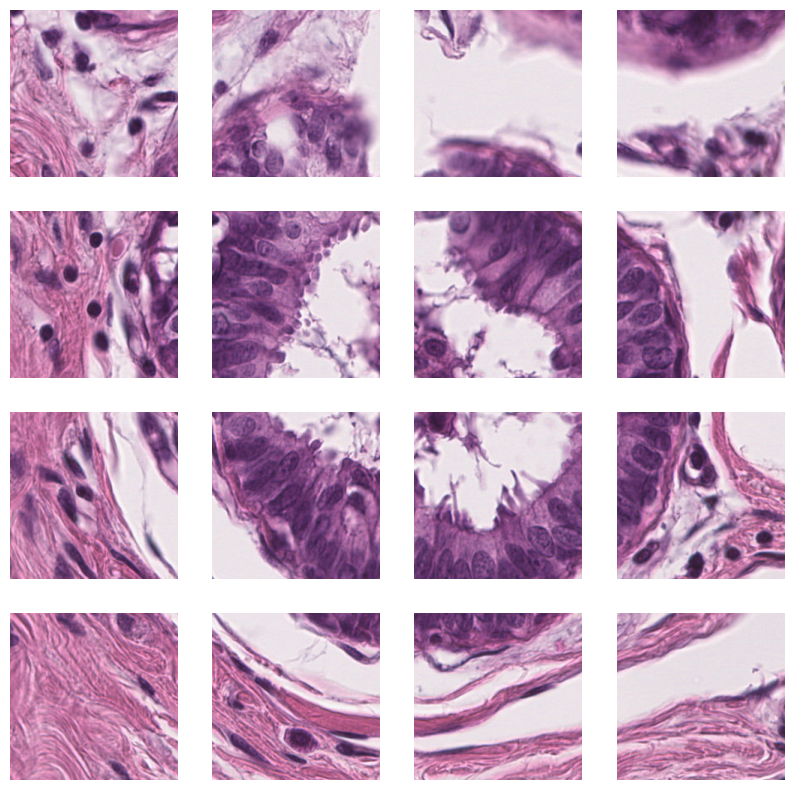

In [23]:
plot_paches(patches)